# **EfficientNetB2**

Error with file: ./Oral_cancer_dataset\cancer\101.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\101.jpeg
Error with file: ./Oral_cancer_dataset\cancer\200.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\200.jpeg
Error with file: ./Oral_cancer_dataset\cancer\273.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\273.jpeg
Error with file: ./Oral_cancer_dataset\cancer\317.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\317.jpeg
Error with file: ./Oral_cancer_dataset\cancer\328.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\328.jpeg
Error with file: ./Oral_cancer_dataset\cancer\407.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\407.jpeg
Error with file: ./Oral_cancer_dataset\cancer\450.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\450.jpeg
Error with file: ./Oral_cancer_dataset\cancer\455.jpeg, Image could not be loaded: ./Oral_cancer_dataset\cancer\455.jpeg
Error with file: ./Oral_cancer_d

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 1.0000 - loss: 0.0075 - precision: 1.0000 - recall: 1.0000
Epoch 15: val_accuracy did not improve from 0.91489
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 1.0000 - loss: 0.0075 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9096 - val_loss: 0.3391 - val_precision: 0.8485 - val_recall: 0.9767 - learning_rate: 1.0000e-04
Epoch 16/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9993 - loss: 0.0102 - precision: 1.0000 - recall: 0.9986
Epoch 16: val_accuracy did not improve from 0.91489
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9993 - loss: 0.0102 - precision: 1.0000 - recall: 0.9985 - val_accuracy: 0.9043 - val_loss: 0.3596 - val_precision: 0.8400 - val_recall: 0.9767 - learning_rate: 1.0000e-04


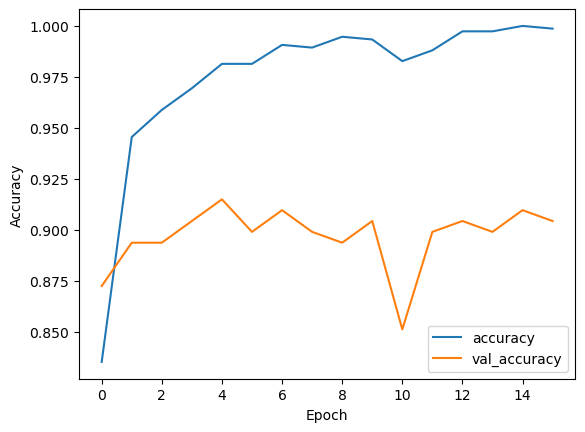

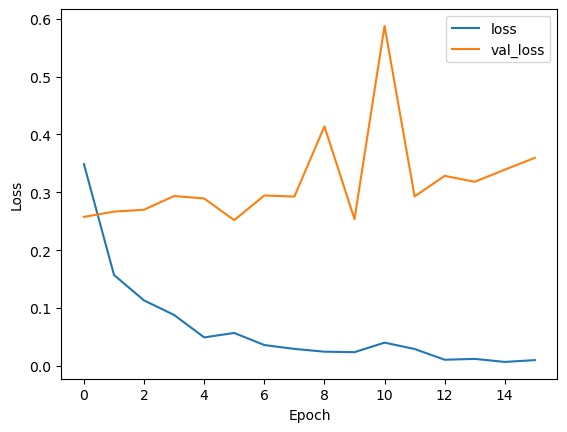

In [4]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model

# Load data
import cv2

def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'no_cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            try:
                # Attempt to load the image using OpenCV
                img = cv2.imread(image_path)
                if img is None:
                    raise ValueError(f"Image could not be loaded: {image_path}")
                img = cv2.resize(img, (260, 260))  # Resize image
                image_array = img_to_array(img)
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error with file: {image_path}, {str(e)}")
    return np.array(images), np.array(labels)


folder_path = './Oral_cancer_dataset'
images, labels = load_data(folder_path)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Define and compile the model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)




model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = './oral_cancer_mode.keras'  # Save in the current directory
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

# Train the model
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [48]:
from PIL import Image

def validate_images(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Verify the image
            except Exception as e:
                print(f"Invalid image: {file_path}, Error: {str(e)}")


In [49]:
validate_images('./Oral_cancer_dataset')

In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('./oral_cancer_mode.keras')

# Ensure the model is loaded correctly
print("Model loaded successfully!")


Model loaded successfully!


In [27]:
test_loss, test_accuracy, test_precision, test_recall = model_EfficientNetB2.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 934ms/step - accuracy: 0.9077 - loss: 0.2365 - precision: 0.9010 - recall: 0.8951
Test Loss: 0.25185835361480713
Test Accuracy: 0.8989361524581909
Test Precision: 0.8764045238494873
Test Recall: 0.9069767594337463


In [50]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read the image: {image_path}")
    img = cv2.resize(img, (260, 260))  # Resize to model input size
    img = img.astype('float32')  # Match training data type
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    prediction = model_EfficientNetB2.predict(img_array)[0][0]  # Sigmoid output
    return prediction, "No Tumor Detected" if prediction > 0.5 else "Tumor Detected"

# Example Test
prediction, result = predict_image('s6.jpeg')
print(f"Raw Prediction: {prediction}")
print(f"Result: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Raw Prediction: 4.5716318709310144e-05
Result: Tumor Detected
